In [1]:
from IPython.core.display import display, HTML # full-width cells
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Import data

For convenience we add some time-series functionality to our default data-storage object, `df`. This lets us down/upsample, format times for plotting purposes, sample specific periods/at certain frequencies, etc.

In [2]:
df = pd.read_csv('data/raw_cycles.csv', header=0).drop(index=[0])
df = df.apply(pd.to_numeric, errors='coerce')
df['Datetime'] = pd.to_datetime(df['Time'], unit='s')
#df.index = df['Datetime']; del df['Datetime']

### Minima,  maxima
Extrema are one-hot encoded categorical variables; cycles begin at a minimum, change direction at a maximum, and end at the following minimum.

In [3]:
from scipy.signal import argrelextrema as extrema
from sklearn.preprocessing import LabelBinarizer

In [4]:
order = 100
minima = extrema(df['Load'].values, comparator=np.less, order=order)[0].tolist()
maxima = extrema(df['Load'].values, comparator=np.greater, order=order)[0].tolist()
df['Min'] = 0; df['Min'].iloc[minima] = 1
df['Max'] = 0; df['Max'].iloc[maxima] = 1

/home/nwchen/.local/lib/python3.5/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


### Cycle labels
Cycles begin and end at consecutive minima. Cycles are labeled at the time marking their beginning, i.e. at the first minima, up to and excluding the next minima.

In [5]:
col = np.empty((df.shape[0],), dtype=int); col[:] = np.nan
for i in range(1, len(minima)):
    col[minima[i-1]:minima[i]] = i
df = df.assign(Cycle=pd.Series(col, index=df.index))

### Area under curve
Areas are either a `float` or `NaN`. Since each cycle has one area value, that value lives in the same row as the `Min` at which the cycle began.

In [6]:
# This generator function keeps track of state, and lets us iterate through values in a lambda expression.
def gen_index():
    length = len(df[df['Min']==1])
    for i in range(length):
        yield i

In [7]:
areas = np.zeros((df.Cycle.max(),))
for cycle in range(df.Cycle.max()):
    cycle_load = df[df.Cycle==cycle].Load.as_matrix()
    cycle_time = df[df.Cycle==cycle].Time.as_matrix()
    areas[cycle] = np.trapz(cycle_load, cycle_time)
areas = areas.tolist(); areas.append(0)

In [8]:
gen = gen_index()
df['Area'] = df[df['Min']==1].apply(lambda row: areas[next(gen)], axis=1)

### Heating and cooling time

In [9]:
heatings = np.zeros((df.Cycle.max(),)) # curve_max - curve_min
for cycle in range(1, df.Cycle.max()):
    h_0 = df.loc[(df['Cycle']==cycle) & (df['Min']==1)]['Time'].values[0]
    h_1 = df.loc[(df['Cycle']==cycle) & (df['Max']==1)]['Time'].values[0]
    heatings[cycle] = h_1 - h_0
heatings = heatings.tolist(); heatings.append(0)

In [10]:
gen = gen_index()
df['Heating'] = df[df['Min']==1].apply(lambda row: heatings[next(gen)], axis=1)

In [11]:
coolings = np.zeros((df.Cycle.max(),)) # curve_max - curve_min
for cycle in range(1, df.Cycle.max()):
    c_0 = df.loc[(df['Cycle']==cycle) & (df['Max']==1)]['Time'].values[0]
    c_1 = df.loc[df['Cycle']==cycle].iloc[-1]['Time']
    coolings[cycle] = c_1 - c_0
coolings = coolings.tolist(); coolings.append(0)

In [12]:
gen = gen_index()
df['Cooling'] = df[df['Min']==1].apply(lambda row: coolings[next(gen)], axis=1)

### Cycle period
This feature is linearly dependent on `heating time` and `cooling time`, but we include it for visualisation/debugging purposes.

In [13]:
df['Period'] = df[df['Min']==1].apply(lambda row: row['Heating']+row['Cooling'], axis=1)

### 10% Load Time
The length of the period over which `Load` is less than 10% of the max load of the cycle. We normalize max load to cycle `max - min`.

In [70]:
tails = np.zeros((df.Cycle.max(),))
for cycle in range(1, df.Cycle.max()):
    maximum = df.loc[(df['Cycle']==cycle) & (df['Max']==1)]['Load'].values[0]
    minimum = df.loc[(df['Cycle']==cycle) & (df['Min']==1)]['Load'].values[0]
    time_at_max = df.loc[(df['Cycle']==cycle) & (df['Max']==1)]['Time'].values[0]
    tenp = 1.0 * (maximum - minimum)
    t_0 = df.loc[(df['Cycle']==cycle) & (df['Time']>(time_at_max)) & (df['Load']<(tenp+minimum))]['Time'].values[0]
    t_1 = df.loc[df['Cycle']==cycle].iloc[-1]['Time']
    tails[cycle] = t_1 - t_0
tails = tails.tolist(); tails.append(0)

In [71]:
gen = gen_index()
df['Tail'] = df[df['Min']==1].apply(lambda row: tails[next(gen)], axis=1)

### Belly of curve
The belly of the curve is the area between the curve as it decreases (cools), and the line joining the max and tail-end min of the curve.

In [126]:
bellies = np.zeros((df.Cycle.max(),))
for cycle in range(1, df.Cycle.max()):
    maximum = df.loc[(df['Cycle']==cycle) & (df['Max']==1)]
    minimum = df.loc[(df['Cycle']==cycle) & (df['Min']==1)]
    y = df.loc[(df['Cycle']==cycle)]['Load'].as_matrix()
    line = np.linspace(maximum['Load'].values[0], minimum['Load'].values[0], y.shape[0])
    bellies[cycle] = np.trapz(line, y)
bellies = bellies.tolist(); bellies.append(0)

In [130]:
gen = gen_index()
df['Belly'] = df[df['Min']==1].apply(lambda row: bellies[next(gen)], axis=1)

## Plot results

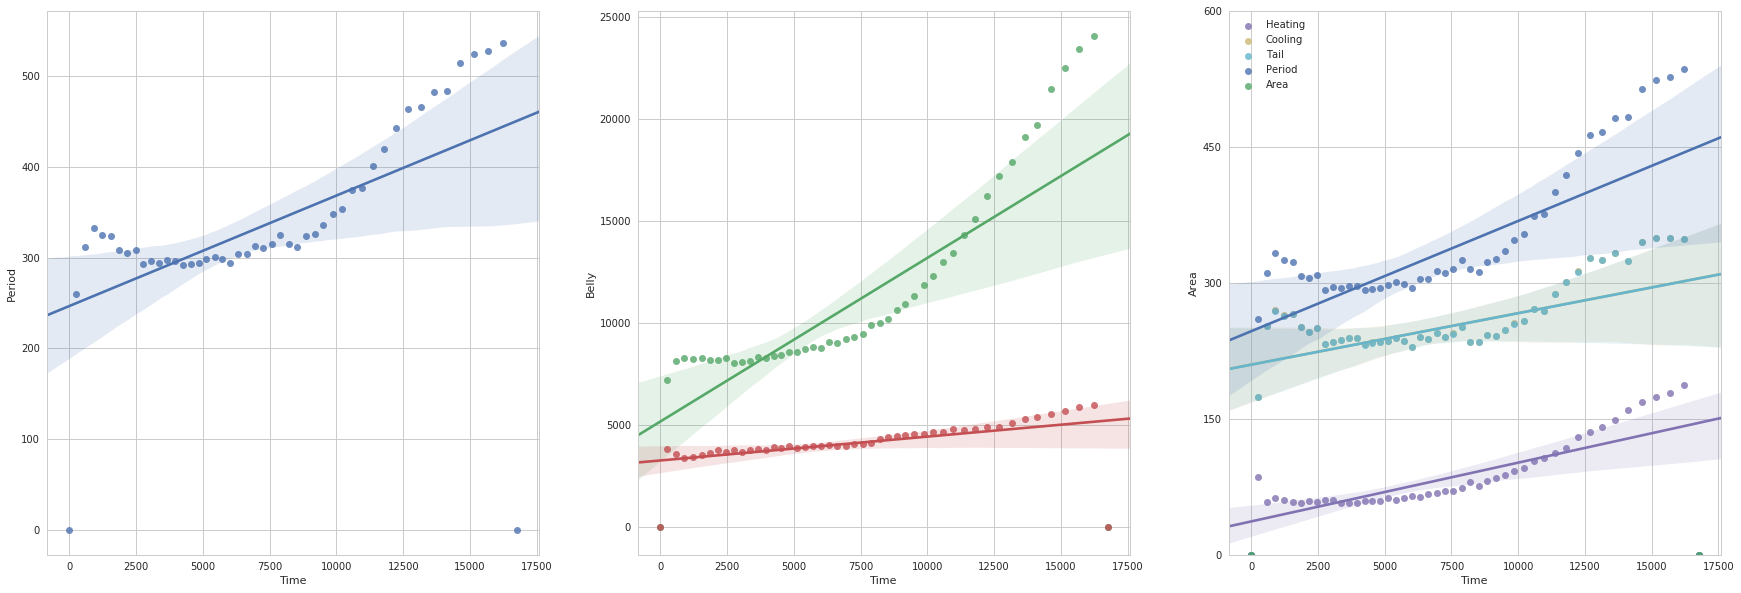

In [149]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30,10))
sns.set()
sns.set_style('whitegrid')
#sns.regplot('Time', 'Heating', df, ax=axes.flat[0]);
#sns.regplot('Time', 'Cooling', df, ax=axes.flat[1])
#sns.regplot('Time', 'Tail', df, ax=axes.flat[2])
sns.regplot('Time', 'Period', df, ax=axes.flat[0], label='Period')
sns.regplot('Time', 'Area', df, ax=axes.flat[1], label='Area')
sns.regplot('Time', 'Belly', df, ax=axes.flat[1], label='Belly')
#plt.legend()

axes.flat[2].set_yticks(np.linspace(0,600,5))
axes.flat[2].set_ylim(0, 600)
sns.regplot('Time', 'Heating', df, ax=axes.flat[2], label='Heating')
sns.regplot('Time', 'Cooling', df, ax=axes.flat[2], label='Cooling')
sns.regplot('Time', 'Tail', df, ax=axes.flat[2], label='Tail')
sns.regplot('Time', 'Period', df, ax=axes.flat[2], label='Period')
sns.regplot('Time', 'Area', df, ax=axes.flat[2], label='Area')
plt.legend()

In [129]:
df[df['Min']==1]

,Time,Load,Datetime,Min,Max,Cycle,Area,Heating,Cooling,Period,Tail,Bellies
19,1.70000,-0.10153,1970-01-01 00:00:01.700000,1,0,1,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000
2677,262.30000,-0.09963,1970-01-01 00:04:22.300000,1,0,2,7194.644662,85.80000,174.69997,260.49997,174.59997,3791.874181
5845,573.89994,0.00872,1970-01-01 00:09:33.899940,1,0,3,8131.923440,58.50000,253.00000,311.50000,252.90000,3574.821393
9225,906.69994,-0.05600,1970-01-01 00:15:06.699940,1,0,4,8249.843636,63.00000,269.70006,332.70006,269.60000,3361.284154
12529,1231.90000,-0.00150,1970-01-01 00:20:31.900000,1,0,5,8198.216090,60.90006,264.19988,325.09994,264.09994,3435.771394
15819,1555.70000,0.02537,1970-01-01 00:25:55.700000,1,0,6,8274.709155,58.00000,265.70000,323.70000,265.60000,3503.137893
18955,1864.00000,-0.61840,1970-01-01 00:31:04.000000,1,0,7,8155.613543,56.69988,251.56487,308.26475,251.46475,3606.542558
22059,2169.09975,-0.09700,1970-01-01 00:36:09.099750,1,0,8,8190.082791,59.50000,245.50000,305.00000,245.40000,3773.309122
25200,2478.00000,-0.21602,1970-01-01 00:41:18.000000,1,0,9,8269.753392,58.10025,250.70000,308.80025,250.60000,3678.514394
28180,2770.80000,0.04363,1970-01-01 00:46:10.800000,1,0,10,8007.463053,60.30000,232.40000,292.70000,232.30000,3734.064579


TODO: area under curve, heating time, cooling time, time of entire curve, time where <10% of force, belly of curve, heating time vs. entire cyle time, heating/cooling proportion wrt first curve